In [41]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter, PercentFormatter
import seaborn as sns
import numpy as np
import os
import math
from collections import defaultdict
from scipy import stats

ModuleNotFoundError: No module named 'scipy'

In [2]:
sns.set()
sns.set_palette('pastel')

## Helpers

In [3]:
def rssi2meters(rssi, tx=-59, N=2):
  return 10 ** (-(rssi - tx) / (10 * N))

In [4]:
def meters2rssi(meters, tx=-59, N=2):
    return -10 * N * math.log10(meters) + tx

In [5]:
class KalmanFilter:
    def __init__(self, process_noise=0.1, sensor_noise=3.5, estimated_error=0, value=None):
        self.process_noise = process_noise
        self.sensor_noise = sensor_noise
        self.estimated_error = estimated_error
        self.prediction_cycles = 0
        self.value = value
        
    def get_filtered_value(self, measurement):
        # prediction phase
        self.estimated_error += self.process_noise
        
        if self.value is None:
            self.value = measurement
        
        # measurement update
        kalman_gain = self.estimated_error / (self.estimated_error + self.sensor_noise)
        self.value = self.value + kalman_gain * (measurement - self.value)
        self.estimated_error = (1 - kalman_gain) * self.estimated_error
        
        return self.value

## Raw Analysis

In [6]:
poi_x, poi_y = (2,5)
close_dist = 1.5
far_dist = 6
data_dir = 'data/exp1-distance'

In [11]:
beacons_positions = {1: (0, 0), 2: (0, 0), 3: (0,0)}

In [7]:
csv_files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]

In [8]:
dfs = [
    pd.read_csv(os.path.join(data_dir, csv), parse_dates=['time']).assign(dataset_index=i + 1)
    for i, csv in enumerate(csv_files)
]
size = len(dfs)
size

3

In [89]:
res_mean = defaultdict(lambda: defaultdict(int))

for N in np.arange(1, 4.01, 0.01):
    
    dfc_all = []
    for i, df in enumerate(dfs):
        df['experiment'] = i
    
        # Step time
        step_times = [
            df[df['xp_step'] == s]['time'].iloc[0]
            for s
            in range(0, max(df['xp_step']+1))
        ]
        step_times.append(max(df['time']))
    
        # Cleaning
        df = df[(df['xp_step'] >= 0)].reset_index(drop=True)
    
        for i in range(1, size+1):
            df[f'ESP32-{i}_new_raw_dist'] = [rssi2meters(v, tx=-69, N=N) for v in df[f'ESP32-{i}_rssi']]
            
            kf = KalmanFilter()
            df[f'ESP32-{i}_filtered_rssi'] = df[f'ESP32-{i}_rssi'].apply(lambda x: kf.get_filtered_value(x))
            
            kf = KalmanFilter()
            df[f'ESP32-{i}_old_filtered_dist'] = df[f'ESP32-{i}_raw_dist'].apply(lambda x: kf.get_filtered_value(x))
            
            kf = KalmanFilter()
            df[f'ESP32-{i}_new_filtered_dist'] = df[f'ESP32-{i}_new_raw_dist'].apply(lambda x: kf.get_filtered_value(x))
    
        # Intermediate steps cleaning
        df = df[df['xp_step'] % 2 == 0].reset_index(drop=True)
    
        # Theory
        theorical_positions = []
    
        for i, row in df.iterrows():
            theorical_positions.append((row['xp_step'] // 2, 0))
            
        df['theorical_x'], df['theorical_y'] = np.array(theorical_positions).T
    
        dfc_all.append(df)
    dfc = pd.concat(dfc_all)

    for i in range(1, size+1):
        dfc[f'ESP32-{i}_theorical_dist'] = ((dfc['theorical_x']-beacons_positions[i][0])**2+(dfc['theorical_y']-beacons_positions[i][1])**2)**0.5
        dfc[f'ESP32-{i}_error_raw_dist'] = abs(dfc[f'ESP32-{i}_theorical_dist']-dfc[f'ESP32-{i}_raw_dist'])
        dfc[f'ESP32-{i}_error_filtered_dist'] = abs(dfc[f'ESP32-{i}_theorical_dist']-dfc[f'ESP32-{i}_filtered_dist'])
        dfc[f'ESP32-{i}_error_new_dist'] = abs(dfc[f'ESP32-{i}_theorical_dist']-dfc[f'ESP32-{i}_new_raw_dist'])
        dfc[f'ESP32-{i}_error_new_filtered_dist'] = abs(dfc[f'ESP32-{i}_theorical_dist']-dfc[f'ESP32-{i}_new_filtered_dist'])


    # Create a list to hold the dataframes for each ESP32
    dfs_list = []
    
    for i in range(1, size+1):
        # Select columns for this ESP32
        cols = [
            f'ESP32-{i}_rssi',
            f'ESP32-{i}_filtered_rssi',
            f'ESP32-{i}_theorical_dist',
            f'ESP32-{i}_error_raw_dist',
            f'ESP32-{i}_error_filtered_dist',
            f'ESP32-{i}_error_new_dist',
            f'ESP32-{i}_error_new_filtered_dist',
            f'ESP32-{i}_raw_dist',
            f'ESP32-{i}_new_raw_dist',
            f'ESP32-{i}_filtered_dist',
            f'ESP32-{i}_new_filtered_dist',
            'experiment',
        ]
        
        # Create a dataframe with only the rows where this ESP32's RSSI is not null
        df_esp = dfc[cols].rename(
            columns={
                f'ESP32-{i}_rssi': 'rssi',
                f'ESP32-{i}_filtered_rssi': 'filtered_rssi',
                f'ESP32-{i}_theorical_dist': 'theorical_dist',
                f'ESP32-{i}_error_raw_dist': 'error_raw_dist',
                f'ESP32-{i}_error_filtered_dist': 'error_filtered_dist',
                f'ESP32-{i}_error_new_dist': 'error_new_dist',
                f'ESP32-{i}_error_new_filtered_dist': 'error_new_filtered_dist',
                f'ESP32-{i}_raw_dist': 'raw_dist',
                f'ESP32-{i}_new_raw_dist': 'new_raw_dist',
                f'ESP32-{i}_filtered_dist': 'filtered_dist',
                f'ESP32-{i}_new_filtered_dist': 'new_filtered_dist',
            }
        )
        
        # Only keep rows where RSSI is not null
        df_esp = df_esp.dropna(subset=['rssi']).copy()
        
        # Add beacon identifier
        df_esp['beacon'] = i
        
        # Add to list if there are any valid rows
        if not df_esp.empty:
            dfs_list.append(df_esp)
    
    # Concatenate all the dataframes
    dft = pd.concat(dfs_list, ignore_index=True)

    res_mean[N] = dft[['error_new_filtered_dist', 'beacon']].groupby('beacon').mean()['error_new_filtered_dist'].to_dict()

In [90]:
sdf_mean = pd.DataFrame.from_dict(res_mean, orient='index')
sdf_mean.columns = ['ESP-1', 'ESP-2', 'ESP-3']
sdf_mean['mean'] = sdf_mean.mean(axis=1)

In [91]:
imin = sdf_mean['mean'].idxmin()
imin

np.float64(2.070000000000001)

In [94]:
sdf_mean.to_csv('data/tmp/mse-n-corridor.csv')

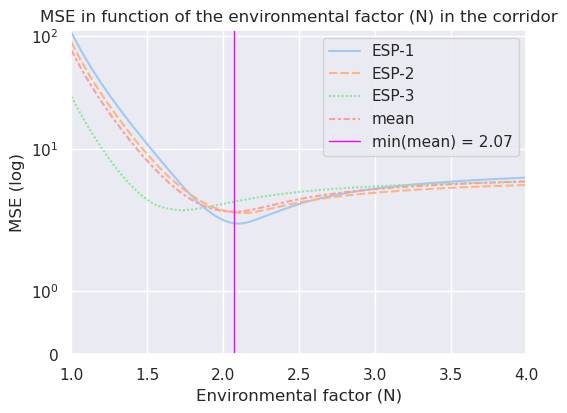

In [92]:
plt.figure(figsize=(5, 4))
plt.subplots_adjust(bottom=0.13, top=0.94, left=0.07, right=0.98)
sns.lineplot(data=sdf_mean)
plt.axvline(x=imin, label=f'min(mean) = {imin:.2f}', color='magenta', lw=1)
plt.legend()
plt.ylim(bottom=0)
plt.xlim((1, 4))
plt.yscale('symlog')
plt.xlabel('Environmental factor (N)')
plt.ylabel('MSE (log)')
plt.title('MSE in function of the environmental factor (N) in the corridor')
plt.savefig('out/beacon-corridor-MSE-N.pdf')